In [224]:
import re
import numpy as np
import pandas as pd

from typing import Optional, List, Dict

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


EXCEL_PATH = "../data/geothermie_gesetz_kommentare.xlsx"
SHEET_NAME = "Gesetz + Kommentare"

df = pd.read_excel(EXCEL_PATH, sheet_name=SHEET_NAME)
df.head()

,Artikel,Typ,Paragraph,Absatz,Gliederungspunkt_Nr,Gesetzestext_Entwurf_1,Gesetzestext_Entwurf_2,Org_2,Org_3,Org_5,...,Org_24,Org_25,Org_26,Org_27,Org_28,Org_29,Org_30,Org_31,Org_32,Org_33
0,1,Allgemeine Anmerkungen,-1,0,NaN,NaN,NaN,Der Beschleunigungseffekt des GeoBG erscheint ...,Bereits jetzt kommt es jedoch durch den zunehm...,Ein wesentliches Hemmnis für den Bau geothermi...,...,NaN,NaN,NaN,NaN,"Grundsätzlich ist ein Mehr an Geothermie, Sole...",Die Dekarbonisierung der Wärmeversorgung ist e...,s.o. § 1,NaN,NaN,NaN
1,1,Paragraph/Absatz,1,0,NaN,Zweck und Ziel des Gesetzes\nZweck dieses Gese...,Zweck und Ziel des Gesetzes\nZweck dieses Gese...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,Paragraph/Absatz,2,0,NaN,Anwendungsbereich\nDieses Gesetz ist anzuwende...,Anwendungsbereich\nDieses Gesetz ist anzuwende...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,Paragraph/Absatz,3,0,NaN,Begriffsbestimmungen\nIm Sinne dieses Gesetzes...,Begriffsbestimmungen\nIm Sinne dieses Gesetzes...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,Paragraph/Absatz,4,0,NaN,Überragendes öffentliches Interesse\nDie Erric...,Überragendes öffentliches Interesse\nDie Erric...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [225]:
# matches: word-<newline>word
HYPHEN_LINEBREAK_RE = re.compile(r"(\w+)-\s*\n\s*(\w+)", flags=re.UNICODE)

# optional: only if you really want to normalize slashes
SLASH_JOIN_RE = re.compile(r"(\w+)\s*/\s*(\w+)", flags=re.UNICODE)


def clean_legal_text(text: Optional[str]) -> str:
    """
    Cleans legal text while preserving semantic hyphenation.
    Only removes hyphens caused by line breaks (e.g. PDF artifacts).
    """
    if text is None or (isinstance(text, float) and np.isnan(text)):
        return ""

    t = str(text)

    # Normalize line endings
    t = t.replace("\r\n", "\n").replace("\r", "\n")

    # Normalize tabs
    t = t.replace("\t", " ")

    # ✅ Remove hyphenation ONLY when caused by line breaks
    # Example: "Ther-\nmal" -> "Thermal"
    # Keeps: "Erdwärme-Anlage", "CO2-Preis"
    t = HYPHEN_LINEBREAK_RE.sub(r"\1\2", t)

    # Replace remaining newlines with spaces
    t = re.sub(r"\n+", " ", t)

    # Optional: normalize slashed compounds (use with care)
    # Example: "Wärme-/Kältespeicher" -> "Wärme- und Kältespeicher"
    t = SLASH_JOIN_RE.sub(r"\1 und \2", t)

    # Collapse whitespace
    t = re.sub(r"\s+", " ", t).strip()

    return t

# apply to all columns
for col in df.columns:
    df[col] = df[col].astype(str).apply(clean_legal_text)

In [226]:
# Example: adjust if your actual column names differ
DRAFT_COLS = [
    "Gesetzestext_Entwurf_1_0307",
    "Gesetzestext_Entwurf_2_1508",
    "Gesetzestext_Entwurf_3_0110",
    "Gesetzestext_Entwurf_4_0312",
]

META_COLS = ["Artikel", "Typ", "Paragraph", "Absatz", "Gliederungspunkt_Nr"]

def get_org_cols(df: pd.DataFrame) -> List[str]:
    return [c for c in df.columns if re.match(r"^Org_\d+$", c)]

#### Aggregate drafts to Artikel-level (recommended)
Why this works for your structure

- Each row is a “unit” (Paragraph/Absatz/Gliederungspunkt or “Allgemeine Anmerkungen”).
- Aggregating by Artikel creates one comparable text per draft per Artikel.

In [80]:
def aggregate_drafts_by_article(
    df: pd.DataFrame,
    draft_cols: List[str],
    include_general_notes: bool = False,
    slash_to_und: bool = True,
) -> pd.DataFrame:
    """
    Returns one row per Artikel with aggregated text for each draft version.
    """

    d = df.copy()

    # clean each draft column
    for col in draft_cols:
        d[col] = d[col].apply(lambda x: clean_legal_text(x))

    # decide which rows to include in the aggregation
    if include_general_notes:
        d_agg = d
    else:
        # exclude "Allgemeine Anmerkungen" rows from the draft-text aggregation
        d_agg = d[d["Typ"].ne("Allgemeine Anmerkungen")].copy()

    # stable ordering within each Artikel:
    # Paragraph, Absatz, Gliederungspunkt_Nr; -1 or NaN will sort to the top/bottom, so we normalize.
    def _to_num(x):
        if pd.isna(x):
            return np.nan
        try:
            return float(x)
        except Exception:
            return np.nan

    for c in ["Paragraph", "Absatz", "Gliederungspunkt_Nr"]:
        if c in d_agg.columns:
            d_agg[c + "_num"] = d_agg[c].apply(_to_num)

    # convert 'Artikel' to int for proper sorting
    def _to_int(x):
        try:
            return int(x)
        except Exception:
            return x
    d_agg["Artikel"] = d_agg["Artikel"].apply(_to_int)
    sort_cols = ["Artikel"]
    for c in ["Paragraph_num", "Absatz_num", "Gliederungspunkt_Nr_num"]:
        if c in d_agg.columns:
            sort_cols.append(c)

    d_agg = d_agg.sort_values(sort_cols, na_position="last")

    # concatenate all units into one text per Artikel per draft
    def _join_nonempty(series: pd.Series) -> str:
        parts = [p for p in series.tolist() if isinstance(p, str) and p.strip()]
        return "\n".join(parts).strip()

    out = (
        d_agg.groupby("Artikel", as_index=False)[draft_cols]
        .agg(_join_nonempty)
    )

    return out

In [ ]:
article_drafts = aggregate_drafts_by_article(
    df,
    draft_cols=DRAFT_COLS,
    include_general_notes=False,  # keep general notes separate
    slash_to_und=True,
)

article_drafts.head()

,Artikel,Gesetzestext_Entwurf_1_0307,Gesetzestext_Entwurf_2_1508,Gesetzestext_Entwurf_3_0110,Gesetzestext_Entwurf_4_0312
0,1,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...
1,2,Änderung des Gesetzes über die Umweltverträgli...,Änderung des Gesetzes über die Umweltverträgli...,Änderung des Gesetzes über die Umweltverträgli...,Änderung des Gesetzes über die Umweltverträgli...
2,3,Änderung der Verwaltungsgerichtsordnung der Di...,Änderung der Verwaltungsgerichtsordnung Die Ve...,Änderung der Verwaltungsgerichtsordnung Die Ve...,Änderung der Verwaltungsgerichtsordnung Die Ve...
3,4,Änderung des Bundesberggesetzes Das Bundesberg...,Änderung des Bundesberggesetzes Das Bundesberg...,Änderung des Bundesberggesetzes Das Bundesberg...,Änderung des Bundesberggesetzes Das Bundesberg...
4,5,Änderung des Wasserhaushaltsgesetzes Das Wasse...,Änderung des Wasserhaushaltsgesetzes Das Wasse...,Änderung des Wasserhaushaltsgesetzes Das Wasse...,Änderung des Wasserhaushaltsgesetzes Das Wasse...


### Artikel-level TF–IDF cosine similarity (v0→v1 and v0→v3 style)

In [89]:
def tfidf_cosine_pairwise(
    texts_a: List[str],
    texts_b: List[str],
    *,
    ngram_range=(1, 2),
    min_df=1,
    max_df=0.95,
) -> np.ndarray:
    """
    Fit TF-IDF on the union of both sets, then compute cosine similarity per pair (a_i vs b_i).
    Returns array of similarities, same length as input.
    """
    corpus = [t or "" for t in texts_a] + [t or "" for t in texts_b]
    vectorizer = TfidfVectorizer(ngram_range=ngram_range, min_df=min_df, max_df=max_df)
    X = vectorizer.fit_transform(corpus)
    Xa = X[: len(texts_a)]
    Xb = X[len(texts_a) :]

    sims = np.array([cosine_similarity(Xa[i], Xb[i])[0, 0] for i in range(len(texts_a))], dtype=float)
    return sims


def compute_article_similarity(
    article_drafts: pd.DataFrame,
    col_a: str,
    col_b: str,
    *,
    ngram_range=(1, 2),
) -> pd.DataFrame:
    """
    Returns a dataframe with one row per Artikel and TF-IDF cosine similarity between two draft columns.
    """
    out = article_drafts[["Artikel", col_a, col_b]].copy()
    sims = tfidf_cosine_pairwise(
        out[col_a].fillna("").tolist(),
        out[col_b].fillna("").tolist(),
        ngram_range=ngram_range,
    )
    out["tfidf_cosine"] = sims

    return out[["Artikel", "tfidf_cosine"]].sort_values("Artikel")

In [90]:
# v0 -> v1 (03.07 -> 15.08)
sim_v0_v1 = compute_article_similarity(
    article_drafts,
    col_a="Gesetzestext_Entwurf_1_0307",
    col_b="Gesetzestext_Entwurf_2_1508",
)

# v0 -> v3 (03.07 -> 03.12)
sim_v0_v3 = compute_article_similarity(
    article_drafts,
    col_a="Gesetzestext_Entwurf_1_0307",
    col_b="Gesetzestext_Entwurf_4_0312",
)

sim_v0_v1, sim_v0_v3

(   Artikel  tfidf_cosine
 0        1      0.966771
 1        2      0.948949
 2        3      0.828402
 3        4      0.969884
 4        5      0.933894
 5        6      1.000000
 6        7      1.000000
 7        8      1.000000
 8        9      1.000000
 9       10      1.000000,
    Artikel  tfidf_cosine
 0        1      0.927868
 1        2      0.901945
 2        3      0.746986
 3        4      0.941778
 4        5      0.912882
 5        6      0.866658
 6        7      0.000000
 7        8      0.000000
 8        9      0.000000
 9       10      0.000000)

In [91]:
def summarize_similarity(sim_df: pd.DataFrame, sim_col: str = "tfidf_cosine") -> Dict[str, float]:
    s = sim_df[sim_col].astype(float).dropna().values
    if len(s) == 0:
        return {"N_articles": 0}

    # p90_delta: 90th percentile of (1 - sim)
    deltas = 1.0 - s

    return {
        "N_articles": int(len(s)),
        "median_sim": float(np.median(s)),
        "p90_delta": float(np.quantile(deltas, 0.90)),
        "pct_sim_ge_0_98": float((s >= 0.98).mean() * 100.0),
    }

summary_v0_v1 = summarize_similarity(sim_v0_v1)
summary_v0_v3 = summarize_similarity(sim_v0_v3)

summary_v0_v1, summary_v0_v3


({'N_articles': 10,
  'median_sim': 0.9849420384925622,
  'p90_delta': 0.07665549580473043,
  'pct_sim_ge_0_98': 50.0},
 {'N_articles': 10,
  'median_sim': 0.8068220396100233,
  'p90_delta': 1.0,
  'pct_sim_ge_0_98': 0.0})

### Convert stakeholder comments wide → long (Org columns)

In [92]:
def comments_wide_to_long(
    df: pd.DataFrame,
    *,
    meta_cols: List[str],
    keep_text_cols: Optional[List[str]] = None,
) -> pd.DataFrame:
    """
    Melt Org_* columns into long format.
    Keeps your unit identifiers (Artikel/Typ/Paragraph/Absatz/Gliederungspunkt_Nr).
    """
    org_cols = get_org_cols(df)

    id_vars = [c for c in meta_cols if c in df.columns]
    if keep_text_cols:
        id_vars += [c for c in keep_text_cols if c in df.columns]

    long = df.melt(
        id_vars=id_vars,
        value_vars=org_cols,
        var_name="Org_Col",
        value_name="Comment_Raw",
    )

    # keep only actual comments
    long["Comment_Raw"] = long["Comment_Raw"].replace({np.nan: ""}).astype(str)
    long["Comment_Raw"] = long["Comment_Raw"].apply(lambda x: "" if x.lower() == "nan" else x)
    long["has_comment"] = long["Comment_Raw"].str.strip().ne("")
    long = long[long["has_comment"]].copy()

    # clean comment text
    long["Comment_Clean"] = long["Comment_Raw"].apply(lambda x: clean_legal_text(x))

    # token proxy (simple): word count; replace with your tokenizer if you want
    long["n_tokens_proxy"] = long["Comment_Clean"].apply(lambda x: len(x.split()) if x else 0)

    return long.drop(columns=["has_comment"])

In [93]:
comments_long = comments_wide_to_long(
    df,
    meta_cols=META_COLS,
    keep_text_cols=None,  # or keep draft cols if you want them in the long table
)

comments_long.head()

,Artikel,Typ,Paragraph,Absatz,Gliederungspunkt_Nr,Org_Col,Comment_Raw,Comment_Clean,n_tokens_proxy
0,1,Allgemeine Anmerkungen,-1,0,nan,Org_2,Der Beschleunigungseffekt des GeoBG erscheint ...,Der Beschleunigungseffekt des GeoBG erscheint ...,89
7,1,Paragraph und Absatz,6,1,nan,Org_2,In diesem Regelungsvorschlag geht es in Absatz...,In diesem Regelungsvorschlag geht es in Absatz...,325
8,1,Paragraph und Absatz,6,2,nan,Org_2,Abzulehnen ist aus den bei § 6 Absatz 1 aufgef...,Abzulehnen ist aus den bei § 6 Absatz 1 aufgef...,32
14,1,Paragraph und Absatz,8,2,nan,Org_2,Der vorliegende Regelungsvorschlag sieht für E...,Der vorliegende Regelungsvorschlag sieht für E...,88
18,1,Paragraph und Absatz,9,1,nan,Org_2,Nach dem geplanten § 9 Absatz 1 Satz 1 sollen ...,Nach dem geplanten § 9 Absatz 1 Satz 1 sollen ...,287


In [94]:
# Example skeleton (replace with your real mapping)
org_map = pd.read_excel(EXCEL_PATH, sheet_name="Org_Map")

# rename Org_ID column for merging
org_map = org_map.rename(columns={"Org_ID": "Org_Col"})

In [95]:
def summarize_comments(comments_long: pd.DataFrame, org_map: Optional[pd.DataFrame] = None) -> pd.DataFrame:
    d = comments_long.copy()
    if org_map is not None:
        d = d.merge(org_map, on="Org_Col", how="left")

    grp_cols = ["Org_Col"]
    if "Organisation_Name" in d.columns:
        grp_cols = ["Organisation_Name", "Organisation_Typ", "Org_Col"]

    # “n_comments”: number of non-empty cells
    # “n_articles_commented”: number of unique Artikel with at least one comment
    out = (
        d.groupby(grp_cols, as_index=False)
        .agg(
            n_comments=("Comment_Clean", "size"),
            n_articles_commented=("Artikel", pd.Series.nunique),
            total_tokens=("n_tokens_proxy", "sum"),
            mean_tokens_per_comment=("n_tokens_proxy", "mean"),
        )
        .sort_values("n_comments", ascending=False)
    )

    # nicer rounding for reporting
    out["mean_tokens_per_comment"] = out["mean_tokens_per_comment"].round(2)
    return out

In [96]:
org_summary = summarize_comments(comments_long, org_map=org_map)  # if you have org_map
org_summary.head(10)

,Organisation_Name,Organisation_Typ,Org_Col,n_comments,n_articles_commented,total_tokens,mean_tokens_per_comment
2,BDEW,Wirtschaftsverband,Org_29,21,6,4417,210.33
28,Verband kommunaler Unternehmen e.V.,Wirtschaftsverband,Org_12,18,4,5479,304.39
18,"Ministerium für Wirtschaft, Industrie, Klimasc...",Land/Landesbehörde,Org_23,16,4,2461,153.81
7,Bundesverband Geothermie e. V.,Wirtschaftsverband,Org_17,14,3,2957,211.21
5,"Bundesverband Erdgas, Erdöl und Geoenergie e.V...",Wirtschaftsverband,Org_16,14,6,1476,105.43
3,Bund für Umwelt und Naturschutz Deutschland e....,Umweltverband,Org_14,13,3,1504,115.69
22,"Niedersächsisches Ministerium für Wirtschaft, ...",Land/Landesbehörde,Org_11,13,6,629,48.38
9,Bundesvereinigung der kommunalen Spitzenverbände,Kommunalverband,Org_30,12,4,2653,221.08
12,Deutsche Umwelthilfe e.V.,Umweltverband,Org_2,11,3,2116,192.36
16,"Ministerium für Energiewende, Klimaschutz, Umw...",Land/Landesbehörde,Org_22,11,5,1179,107.18


In [108]:
def aggregate_comments_by_article_org(comments_long: pd.DataFrame, org_map: Optional[pd.DataFrame] = None) -> pd.DataFrame:
    d = comments_long.copy()
    if org_map is not None:
        d = d.merge(org_map, on="Org_Col", how="left")

    key_cols = ["Artikel", "Org_Col"]
    if "Organisation_Name" in d.columns:
        key_cols = ["Artikel", "Organisation_Name", "Organisation_Typ", "Org_Col"]

    def _join(series: pd.Series) -> str:
        parts = [x for x in series.tolist() if isinstance(x, str) and x.strip()]
        return "\n".join(parts).strip()

    out = (
        d.groupby(key_cols, as_index=False)
        .agg(
            comment_text=("Comment_Clean", _join),
            n_units_commented=("Comment_Clean", "size"),
            total_tokens=("n_tokens_proxy", "sum"),
        )
    )

    # convert 'Artikel' to int for proper sorting
    def _to_int(x):
        try:
            return int(x)
        except Exception:
            return x
    out["Artikel"] = out["Artikel"].apply(_to_int)
    out = out.sort_values(["Artikel", "Organisation_Name" if "Organisation_Name" in out.columns else "Org_Col"])

    return out

In [109]:
article_org_comments = aggregate_comments_by_article_org(comments_long, org_map=org_map)
article_org_comments.head()

,Artikel,Organisation_Name,Organisation_Typ,Org_Col,comment_text,n_units_commented,total_tokens
0,1,8KU GmbH,Unternehmen,Org_15,Die Regelung zur seismischen Exploration wird ...,7,460
1,1,"AGFW | Der Energieeffizienzverband für Wärme, ...",Wirtschaftsverband,Org_13,Privilegierung im Außenbereich: Wir sehen gera...,7,448
2,1,BDEW,Wirtschaftsverband,Org_29,Die Dekarbonisierung der Wärmeversorgung ist e...,8,1587
3,1,Bund für Umwelt und Naturschutz Deutschland e....,Umweltverband,Org_14,Ein zentrales Problem wird durch das Gesetz ni...,6,814
4,1,Bundesverband Deutscher Wasserkraftwerke (BDW)...,Wirtschaftsverband,Org_8,Neben der Geothermie werden weitere Optionen z...,1,108


In [100]:
# print first full comment
article_org_comments.comment_text[0]

'Die Regelung zur seismischen Exploration wird begrüßt.\nDie Regelung zur seismischen Exploration wird begrüßt.\nDie Regelung zu Ansprüchen bei Nutzungsbeeinträchtigungen wird begrüßt.\nDie Regelungsvorschläge in § 8 zur Planfeststellung sind geeignet, Beschleunigungen herbeizuführen. Aus der Praxiserfahrung heraus wird empfohlen, einen Gleichlauf der Verfahren für Energieleitungen und Wärmeleitungen herbeizuführen. Dies könnte durch Ergänzung der §§ 43e, 44a u. 44b EnWG geschehen.\nDie Regelung zu Rechtsbehelfen wird begrüßt.\nDie Regelung zur Zuständigkeit von Oberverwaltungsgerichten wird begrüßt.\nIn den vorliegenden Vorschlägen sind eine Reihe von nötigen Erweiterungen noch nicht erkennbar: Grundlegender Vorrang für EE-Wärme (BauGB) Eine große Herausforderung bei der Entwicklung von Tiefengeothermie-Projekten stellt die Grundstückverfügbarkeit dar. Wie andere erneuerbare Energien (Wind, PV, Biomasse und Wasserenergie), sollte in Ergänzung zum vorliegenden Entwurf der Privilegierun

## Embeddings

In [110]:
import pandas as pd
import numpy as np

TEXT_COLS = [
    "Gesetzestext_Entwurf_1_0307",
    "Gesetzestext_Entwurf_2_1508",
    "Gesetzestext_Entwurf_3_0110",
    "Gesetzestext_Entwurf_4_0312",
]

def build_article_text_table(df_paragraph_level: pd.DataFrame) -> pd.DataFrame:
    """
    From your paragraph-level law dataframe (with Artikel/Typ/Paragraph/Absatz/...),
    build ONE row per Artikel containing concatenated text for each version.
    """
    tmp = df_paragraph_level.copy()

    # Keep only rows that actually contain law text (drop general comment rows etc.)
    # This avoids Artikel-level text being polluted by NaNs or "Allgemeine Anmerkungen" rows.
    tmp = tmp[tmp[TEXT_COLS].notna().any(axis=1)].copy()

    # Ensure stable ordering inside each Artikel before concatenation
    # (adjust if your ordering columns differ)
    order_cols = ["Artikel", "Paragraph", "Absatz", "Gliederungspunkt_Nr"]
    for c in order_cols:
        if c not in tmp.columns:
            tmp[c] = np.nan

    tmp = tmp.sort_values(order_cols, kind="mergesort")

    def concat_series(s: pd.Series) -> str:
        parts = [str(x).strip() for x in s.dropna().tolist() if str(x).strip()]
        return "\n".join(parts)  # keep structure; can swap to " " if you prefer

    article_text = (
        tmp.groupby("Artikel", as_index=False)
           .agg({col: concat_series for col in TEXT_COLS})
    )

    # Optional: shorter names
    article_text = article_text.rename(columns={
        "Gesetzestext_Entwurf_1_0307": "text_v0_0307",
        "Gesetzestext_Entwurf_2_1508": "text_v1_1508",
        "Gesetzestext_Entwurf_3_0110": "text_v2_0110",
        "Gesetzestext_Entwurf_4_0312": "text_v3_0312",
    })

    # convert 'Artikel' to int for proper sorting
    def _to_int(x):
        try:
            return int(x)
        except Exception:
            return x

    return article_text

# Example usage:
# df_law_paragraphs = your original dataframe with 40 columns (law text + Org_*)
article_text = build_article_text_table(article_drafts)

article_text.head()

,Artikel,text_v0_0307,text_v1_1508,text_v2_0110,text_v3_0312
0,1,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...
1,2,Änderung des Gesetzes über die Umweltverträgli...,Änderung des Gesetzes über die Umweltverträgli...,Änderung des Gesetzes über die Umweltverträgli...,Änderung des Gesetzes über die Umweltverträgli...
2,3,Änderung der Verwaltungsgerichtsordnung der Di...,Änderung der Verwaltungsgerichtsordnung Die Ve...,Änderung der Verwaltungsgerichtsordnung Die Ve...,Änderung der Verwaltungsgerichtsordnung Die Ve...
3,4,Änderung des Bundesberggesetzes Das Bundesberg...,Änderung des Bundesberggesetzes Das Bundesberg...,Änderung des Bundesberggesetzes Das Bundesberg...,Änderung des Bundesberggesetzes Das Bundesberg...
4,5,Änderung des Wasserhaushaltsgesetzes Das Wasse...,Änderung des Wasserhaushaltsgesetzes Das Wasse...,Änderung des Wasserhaushaltsgesetzes Das Wasse...,Änderung des Wasserhaushaltsgesetzes Das Wasse...


In [111]:
article_org_comments.dtypes

Artikel               int64
Organisation_Name    object
Organisation_Typ     object
Org_Col              object
comment_text         object
n_units_commented     int64
total_tokens          int64
dtype: object

In [112]:
# Quick sanity checks
assert "Artikel" in article_org_comments.columns, "article_org_comments needs an 'Artikel' column"
assert "Artikel" in article_text.columns, "article_text needs an 'Artikel' column"

df_for_embeddings = (
    article_org_comments
      .merge(article_text, on="Artikel", how="left", validate="m:1")
)

df_for_embeddings.head()

,Artikel,Organisation_Name,Organisation_Typ,Org_Col,comment_text,n_units_commented,total_tokens,text_v0_0307,text_v1_1508,text_v2_0110,text_v3_0312
0,1,8KU GmbH,Unternehmen,Org_15,Die Regelung zur seismischen Exploration wird ...,7,460,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...
1,1,"AGFW | Der Energieeffizienzverband für Wärme, ...",Wirtschaftsverband,Org_13,Privilegierung im Außenbereich: Wir sehen gera...,7,448,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...
2,1,BDEW,Wirtschaftsverband,Org_29,Die Dekarbonisierung der Wärmeversorgung ist e...,8,1587,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...
3,1,Bund für Umwelt und Naturschutz Deutschland e....,Umweltverband,Org_14,Ein zentrales Problem wird durch das Gesetz ni...,6,814,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...
4,1,Bundesverband Deutscher Wasserkraftwerke (BDW)...,Wirtschaftsverband,Org_8,Neben der Geothermie werden weitere Optionen z...,1,108,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...


In [128]:
# print total tokens by article
df_for_embeddings.groupby("Artikel")["total_tokens"].sum()

# print mean tokens for each article
df_for_embeddings.groupby("Artikel")["total_tokens"].mean()

# total mean
df_for_embeddings["total_tokens"].mean()

np.float64(424.82954545454544)

In [133]:
# calaculate avarage comment length, for non-empty comments
df_for_embeddings["total_tokens"].mean()

np.float64(424.82954545454544)

In [113]:
# pick the right column name
COMMENT_COL = "comment_text"  # <- change if yours differs

df_for_embeddings["comment_clean"] = df_for_embeddings[COMMENT_COL].apply(clean_legal_text)

# If you also want cleaned law text (optional, but consistent preprocessing helps)
for col in ["text_v0_0307", "text_v1_1508", "text_v2_0110", "text_v3_0312"]:
    df_for_embeddings[col + "_clean"] = df_for_embeddings[col].apply(clean_legal_text)

df_for_embeddings[["Artikel", "comment_clean", "text_v0_0307"]].head()


,Artikel,comment_clean,text_v0_0307
0,1,Die Regelung zur seismischen Exploration wird ...,Zweck und Ziel des Gesetzes Zweck dieses Geset...
1,1,Privilegierung im Außenbereich: Wir sehen gera...,Zweck und Ziel des Gesetzes Zweck dieses Geset...
2,1,Die Dekarbonisierung der Wärmeversorgung ist e...,Zweck und Ziel des Gesetzes Zweck dieses Geset...
3,1,Ein zentrales Problem wird durch das Gesetz ni...,Zweck und Ziel des Gesetzes Zweck dieses Geset...
4,1,Neben der Geothermie werden weitere Optionen z...,Zweck und Ziel des Gesetzes Zweck dieses Geset...


In [114]:
df_for_embeddings

,Artikel,Organisation_Name,Organisation_Typ,Org_Col,comment_text,n_units_commented,total_tokens,text_v0_0307,text_v1_1508,text_v2_0110,text_v3_0312,comment_clean,text_v0_0307_clean,text_v1_1508_clean,text_v2_0110_clean,text_v3_0312_clean
0,1,8KU GmbH,Unternehmen,Org_15,Die Regelung zur seismischen Exploration wird ...,7,460,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Die Regelung zur seismischen Exploration wird ...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...
1,1,"AGFW | Der Energieeffizienzverband für Wärme, ...",Wirtschaftsverband,Org_13,Privilegierung im Außenbereich: Wir sehen gera...,7,448,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Privilegierung im Außenbereich: Wir sehen gera...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...
2,1,BDEW,Wirtschaftsverband,Org_29,Die Dekarbonisierung der Wärmeversorgung ist e...,8,1587,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Die Dekarbonisierung der Wärmeversorgung ist e...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...
3,1,Bund für Umwelt und Naturschutz Deutschland e....,Umweltverband,Org_14,Ein zentrales Problem wird durch das Gesetz ni...,6,814,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Ein zentrales Problem wird durch das Gesetz ni...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...
4,1,Bundesverband Deutscher Wasserkraftwerke (BDW)...,Wirtschaftsverband,Org_8,Neben der Geothermie werden weitere Optionen z...,1,108,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Neben der Geothermie werden weitere Optionen z...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,6,"Bundesverband Erdgas, Erdöl und Geoenergie e.V...",Wirtschaftsverband,Org_16,Keine Anmerkungen.,1,2,Inkrafttreten Dieses Gesetz tritt vorbehaltlic...,Inkrafttreten Dieses Gesetz tritt vorbehaltlic...,Inkrafttreten Dieses Gesetz tritt vorbehaltlic...,Inkrafttreten (1) Dieses Gesetz tritt vorbehal...,Keine Anmerkungen.,Inkrafttreten Dieses Gesetz tritt vorbehaltlic...,Inkrafttreten Dieses Gesetz tritt vorbehaltlic...,Inkrafttreten Dieses Gesetz tritt vorbehaltlic...,Inkrafttreten (1) Dieses Gesetz tritt vorbehal...
84,6,Bundesvereinigung der kommunalen Spitzenverbände,Kommunalverband,Org_30,Die kommunalen Spitzenverbände haben über die ...,1,22,Inkrafttreten Dieses Gesetz tritt vorbehaltlic...,Inkrafttreten Dieses Gesetz tritt vorbehaltlic...,Inkrafttreten Dieses Gesetz tritt vorbehaltlic...,Inkrafttreten (1) Dieses Gesetz tritt vorbehal...,Die

In [137]:
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

MODEL_NAME = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
model = SentenceTransformer(MODEL_NAME)

In [115]:
from typing import List

def embed_texts(texts: List[str], batch_size: int = 32) -> np.ndarray:
    """
    Returns embeddings with shape [n_texts, dim].
    Empty strings are allowed; they will still get an embedding.
    """
    texts = ["" if (t is None or (isinstance(t, float) and np.isnan(t))) else str(t) for t in texts]
    emb = model.encode(
        texts,
        batch_size=batch_size,
        show_progress_bar=True,
        normalize_embeddings=True,  # important for cosine similarity stability
    )
    return np.asarray(emb)

In [116]:
# --- rename here if needed ---
# expected columns:
# Artikel, Org_ID, comment_clean, text_v0_0307_clean (or whatever baseline draft you want)
required_cols = ["Artikel", "Org_Col", "comment_clean", "text_v0_0307_clean"]
missing = [c for c in required_cols if c not in df_for_embeddings.columns]
if missing:
    raise ValueError(f"df_for_embeddings missing columns: {missing}")

df_emb = df_for_embeddings.copy()

# basic hygiene (keep it minimal)
df_emb["comment_clean"] = df_emb["comment_clean"].fillna("").astype(str).str.strip()
df_emb["text_v0_0307_clean"] = df_emb["text_v0_0307_clean"].fillna("").astype(str).str.strip()

# mark whether an org commented on that article
df_emb["has_comment"] = df_emb["comment_clean"].str.len().gt(0)

# embeddings
comment_embeddings = embed_texts(df_emb["comment_clean"].tolist(), batch_size=32)
law_embeddings = embed_texts(df_emb["text_v0_0307_clean"].tolist(), batch_size=32)

df_emb["emb_comment"] = list(comment_embeddings)
df_emb["emb_law_v0"] = list(law_embeddings)

# similarity: comment ↔ baseline law text
# cosine similarity for normalized vectors is dot product
df_emb["sim_comment_to_v0"] = np.sum(comment_embeddings * law_embeddings, axis=1)

df_emb.head()

Batches: 100%|██████████| 3/3 [00:00<00:00,  6.16it/s]


,Artikel,Organisation_Name,Organisation_Typ,Org_Col,comment_text,n_units_commented,total_tokens,text_v0_0307,text_v1_1508,text_v2_0110,text_v3_0312,comment_clean,text_v0_0307_clean,text_v1_1508_clean,text_v2_0110_clean,text_v3_0312_clean,has_comment,emb_comment,emb_law_v0,sim_comment_to_v0
0,1,8KU GmbH,Unternehmen,Org_15,Die Regelung zur seismischen Exploration wird ...,7,460,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Die Regelung zur seismischen Exploration wird ...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,True,"[-0.05149633, -0.015539503, -0.018394893, 0.00...","[-0.047638148, 0.052885942, -0.020231886, 0.07...",0.470582
1,1,"AGFW | Der Energieeffizienzverband für Wärme, ...",Wirtschaftsverband,Org_13,Privilegierung im Außenbereich: Wir sehen gera...,7,448,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Privilegierung im Außenbereich: Wir sehen gera...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,True,"[-0.037216727, 0.04132272, 0.053244382, 0.0248...","[-0.047638148, 0.052885942, -0.020231886, 0.07...",0.667427
2,1,BDEW,Wirtschaftsverband,Org_29,Die Dekarbonisierung der Wärmeversorgung ist e...,8,1587,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Die Dekarbonisierung der Wärmeversorgung ist e...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,True,"[-0.07001478, -0.029068206, -0.030728754, 0.05...","[-0.047638148, 0.052885942, -0.020231886, 0.07...",0.628732
3,1,Bund für Umwelt und Naturschutz Deutschland e....,Umweltverband,Org_14,Ein zentrales Problem wird durch das Gesetz ni...,6,814,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Ein zentrales Problem wird durch das Gesetz ni...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,True,"[-0.08748708, 0.053856768, 0.029530281, 0.0833...","[-0.047638148, 0.052885942, -0.020231886, 0.07...",0.542579
4,1,Bundesverband Deutscher Wasserkraftwerke (BDW)...,Wirtschaftsverband,Org_8,Neben der Geothermie werden weitere Optionen z...,1,108,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Neben der Geothermie werden weitere Optionen z...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,True,"[-0.019090088, 0.023548327, 0.018874437, -0.01...","[-0.047638148, 0.052885942, -0.020231886, 0.07...",0.522864


In [117]:
# sanity check
assert "text_v1_1508_clean" in df_emb.columns, "Missing law_text_v1 column"

# embed v1 law text
law_v1_embeddings = embed_texts(
    df_emb["text_v1_1508_clean"].fillna("").astype(str).tolist(),
    batch_size=32,
)

df_emb["emb_law_v1"] = list(law_v1_embeddings)

Batches: 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]


In [119]:
# comment_embeddings already exists from earlier
df_emb["sim_comment_to_v1"] = np.sum(
    comment_embeddings * law_v1_embeddings,
    axis=1,
)

In [120]:
df_emb["delta_alignment"] = (
    df_emb["sim_comment_to_v1"] - df_emb["sim_comment_to_v0"]
)

In [139]:
selected_orgs = [
    "BDEW",
    "Deutsche Umwelthilfe e.V.",
    "Bundesverband Geothermie e.V.",
    "Verband kommunaler Unternehmen e.V.",
    "NABU (Naturschutzbund Deutschland) e.V."
]

df_sel = df_emb[
    (df_emb["Organisation_Name"].isin(selected_orgs)) &
    (df_emb["has_comment"])
].copy()


In [141]:
org_emb = (
    df_sel.groupby(["Organisation_Name", "Organisation_Typ"])["emb_comment"]
    .apply(lambda x: np.mean(np.vstack(x), axis=0))
    .reset_index()
)


In [121]:
df_emb[["sim_comment_to_v0", "sim_comment_to_v1", "delta_alignment"]].describe()

,sim_comment_to_v0,sim_comment_to_v1,delta_alignment
count,88.000000,88.000000,88.000000
mean,0.466909,0.485417,0.018508
std,0.144155,0.146582,0.035273
min,0.025110,0.026915,-0.093529
25%,0.439698,0.445499,-0.001077
50%,0.491511,0.509571,0.018035
75%,0.550472,0.570225,0.033539
max,0.707195,0.721093,0.118774


In [122]:
article_alignment = (
    df_emb[df_emb["has_comment"]]
    .groupby("Artikel")
    .agg(
        n_orgs=("delta_alignment", "size"),
        median_delta=("delta_alignment", "median"),
        mean_delta=("delta_alignment", "mean"),
    )
    .reset_index()
)

article_alignment

,Artikel,n_orgs,median_delta,mean_delta
0,1,25,0.020155,0.021334
1,2,9,-0.009152,-0.008880
2,3,7,0.015773,0.017973
3,4,21,0.020878,0.023906
4,5,20,0.025100,0.027372
5,6,6,0.000000,0.000000


In [123]:
orgtype_alignment = (
    df_emb[df_emb["has_comment"]]
    .groupby("Organisation_Typ")
    .agg(
        n_obs=("delta_alignment", "size"),
        median_delta=("delta_alignment", "median"),
        mean_delta=("delta_alignment", "mean"),
    )
    .reset_index()
)

orgtype_alignment


,Organisation_Typ,n_obs,median_delta,mean_delta
0,Andere,2,0.023621,0.023621
1,Kommunalverband,4,0.008871,0.020326
2,Land/Landesbehörde,26,0.010469,0.014112
3,Umweltverband,9,0.026029,0.024573
4,Unternehmen,11,0.020155,0.028495
5,Wirtschaftsverband,36,0.017692,0.016628


In [124]:
org_alignment = (
    df_emb[df_emb["has_comment"]]
    .groupby(["Organisation_Name", "Organisation_Typ"])
    .agg(
        n_articles=("Artikel", "nunique"),
        n_comments=("delta_alignment", "size"),
        median_delta=("delta_alignment", "median"),
        mean_delta=("delta_alignment", "mean"),
        share_positive=("delta_alignment", lambda x: (x > 0).mean()),
    )
    .reset_index()
    .sort_values("median_delta", ascending=False)
)

org_alignment_filtered = org_alignment[org_alignment["n_articles"] >= 2]
org_alignment_filtered

,Organisation_Name,Organisation_Typ,n_articles,n_comments,median_delta,mean_delta,share_positive
21,NABU (Naturschutzbund Deutschland) e.V.,Umweltverband,3,3,0.069065,0.059181,1.000000
0,8KU GmbH,Unternehmen,3,3,0.054937,0.058071,1.000000
20,"Ministerium für Wissenschaft, Energie, Klimasc...",Land/Landesbehörde,2,2,0.054811,0.054811,0.500000
7,Bundesverband Geothermie e. V.,Wirtschaftsverband,3,3,0.050957,0.042233,1.000000
15,Kunststoffrohrverband e.V.,Wirtschaftsverband,2,2,0.045040,0.045040,1.000000
25,"Thüringer Ministerium für Umwelt, Energie, Nat...",Land/Landesbehörde,3,3,0.033391,0.022139,0.666667
3,Bund für Umwelt und Naturschutz Deutschland e....,Umweltverband,3,3,0.031949,0.012952,0.666667
6,Bundesverband Erneuerbare Energie e.V.,Wirtschaftsverband,2,2,0.029095,0.029095,1.000000
19,"Ministerium für Wirtschaft, Infrastruktur, Tou...",Land/Landesbehörde,3,3,0.027946,0.024614,0.666667
29,Vulcan Energie Ressourcen GmbH,Unternehmen,3,3,0.026762,0.041146,1.000000


In [158]:
print(df_emb[
    ["sim_comment_to_v0", "sim_comment_to_v1", "delta_alignment"]
].describe())

       sim_comment_to_v0  sim_comment_to_v1  delta_alignment
count          88.000000          88.000000        88.000000
mean            0.466909           0.485417         0.018508
std             0.144155           0.146582         0.035273
min             0.025110           0.026915        -0.093529
25%             0.439698           0.445499        -0.001077
50%             0.491511           0.509571         0.018035
75%             0.550472           0.570225         0.033539
max             0.707195           0.721093         0.118774


<Figure size 600x400 with 0 Axes>

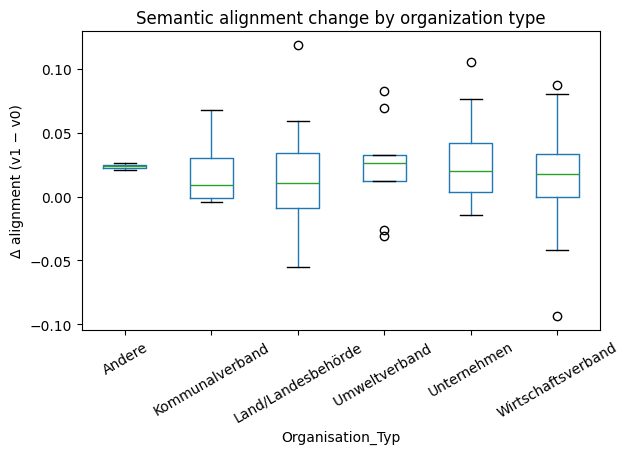

In [146]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
df_emb[df_emb["has_comment"]].boxplot(
    column="delta_alignment",
    by="Organisation_Typ",
    grid=False,
    rot=30,
)
plt.title("Semantic alignment change by organization type")
plt.suptitle("")
plt.ylabel("Δ alignment (v1 − v0)")
plt.tight_layout()
plt.show()


In [148]:
### another embedding model

from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np

tokenizer = AutoTokenizer.from_pretrained("deepset/gbert-base")
model = AutoModel.from_pretrained("deepset/gbert-base")
model.eval()

def embed_texts_gbert(
    texts,
    max_length=512,
    batch_size=8,
):
    """
    Compute mean-pooled GBERT embeddings for a list of texts.
    Returns a numpy array of shape [n_texts, 768].
    """
    all_embeddings = []

    for i in range(0, len(texts), batch_size):
        batch = texts[i : i + batch_size]

        batch = [
            "" if (t is None or (isinstance(t, float) and np.isnan(t))) else str(t)
            for t in batch
        ]

        inputs = tokenizer(
            batch,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt",
        )

        with torch.no_grad():
            outputs = model(**inputs)
            # mean pooling over token dimension
            emb = outputs.last_hidden_state.mean(dim=1)

        # L2 normalization
        emb = emb / emb.norm(dim=1, keepdim=True)
        all_embeddings.append(emb.cpu().numpy())

    return np.vstack(all_embeddings)



In [149]:
comment_texts = (
    df_emb["comment_text"]
    .fillna("")
    .astype(str)
    .tolist()
)

comment_embeddings_gbert = embed_texts_gbert(
    comment_texts,
    batch_size=8,   # safe on Colab / laptop
)

comment_embeddings_gbert.shape
# → (n_rows, 768)

(88, 768)

In [150]:
df_emb["emb_comment_gbert"] = list(comment_embeddings_gbert)

In [154]:
law_v0_texts = df_emb["text_v0_0307_clean"].fillna("").astype(str).tolist()
law_v1_texts = df_emb["text_v1_1508_clean"].fillna("").astype(str).tolist()

emb_law_v0_gbert = embed_texts_gbert(law_v0_texts)
emb_law_v1_gbert = embed_texts_gbert(law_v1_texts)

df_emb["emb_law_v0_gbert"] = list(emb_law_v0_gbert)
df_emb["emb_law_v1_gbert"] = list(emb_law_v1_gbert)

In [155]:
df_emb["sim_comment_to_v0_gbert"] = np.sum(
    np.vstack(df_emb["emb_comment_gbert"].values)
    * np.vstack(df_emb["emb_law_v0_gbert"].values),
    axis=1,
)

df_emb["sim_comment_to_v1_gbert"] = np.sum(
    np.vstack(df_emb["emb_comment_gbert"].values)
    * np.vstack(df_emb["emb_law_v1_gbert"].values),
    axis=1,
)

df_emb["delta_alignment_gbert"] = (
    df_emb["sim_comment_to_v1_gbert"]
    - df_emb["sim_comment_to_v0_gbert"]
)

In [157]:
print(df_emb[
    ["sim_comment_to_v0_gbert", "sim_comment_to_v1_gbert", "delta_alignment_gbert"]
].describe())


       sim_comment_to_v0_gbert  sim_comment_to_v1_gbert  delta_alignment_gbert
count                88.000000                88.000000              88.000000
mean                  0.756107                 0.753192              -0.002916
std                   0.160020                 0.161630               0.006712
min                   0.297871                 0.292097              -0.021555
25%                   0.655451                 0.659288              -0.006330
50%                   0.799771                 0.791920              -0.002470
75%                   0.893398                 0.892106               0.001152
max                   0.939569                 0.942957               0.010190


### Whole documents analysis

In [163]:
import re
import numpy as np

def normalize_text(s: str) -> str:
    s = s.replace("\t", " ").replace("\r\n", "\n").replace("\r", "\n")
    s = re.sub(r"\n+", "\n", s)
    s = re.sub(r"\s+", " ", s)
    return s.strip()

def build_law_docs(df_law, draft_cols):
    """
    draft_cols: dict like {"v0": colname, "v1": colname, ...}
    Returns dict: {version: full_document_text}
    """
    docs = {}

    for version, col in draft_cols.items():
        tmp = df_law.copy()

        # exclude non-law rows
        if "Typ" in tmp.columns:
            tmp = tmp[tmp["Typ"] != "Allgemeine Anmerkungen"]

        texts = (
            tmp[col]
            .dropna()
            .astype(str)
            .map(normalize_text)
            .tolist()
        )

        docs[version] = "\n\n".join(texts)

    return docs

draft_cols = {
    "v0": "Gesetzestext_Entwurf_1_0307",
    "v1": "Gesetzestext_Entwurf_2_1508",
    "v2": "Gesetzestext_Entwurf_3_0110",
    "v3": "Gesetzestext_Entwurf_4_0312",
}

law_docs = build_law_docs(df, draft_cols)

for k, v in law_docs.items():
    print(k, "chars:", len(v))

v0 chars: 26627
v1 chars: 27856
v2 chars: 28056
v3 chars: 35656


In [175]:
law_docs

{'v0': 'Zweck und Ziel des Gesetzes Zweck dieses Gesetzes ist die Schaffung rechtlicher Rahmenbedingungen für den vereinfachten und beschleunigten Ausbau einer Infrastruktur für die Aufsuchung, die Gewinnung sowie die Nutzung von Geothermie sowie für den Ausbau von Wärmepumpen sowie von Wärmespeichern. Dieses Gesetz soll einen Beitrag zur Erreichung der nationalen Klimaschutzziele und zur Ausschöpfung des vorhandenen geothermischen Potenzials leisten, um die sichere und umweltverträgliche Aufsuchung, Gewinnung und Nutzung treibhausgasneutraler Wärme und Kälte sicherzustellen.\n\nAnwendungsbereich Dieses Gesetz ist anzuwenden auf die Zulassung der nachstehenden Anlagen und Leitungen, einschließlich der jeweils dazugehörigen Nebenanlagen und Bohrungen: 1. einer Anlage zur Aufsuchung oder Gewinnung von Tiefengeothermie, 2. einer Anlage zur Aufsuchung oder Gewinnung von oberflächennaher Geothermie, 3. einer Wärmepumpe, 4. eines Wärmespeichers 5. einer Wärmeleitung.\n\nBegriffsbestimmungen 

In [177]:
# extract text of 'v0'
law_docs.get('v0')

'Zweck und Ziel des Gesetzes Zweck dieses Gesetzes ist die Schaffung rechtlicher Rahmenbedingungen für den vereinfachten und beschleunigten Ausbau einer Infrastruktur für die Aufsuchung, die Gewinnung sowie die Nutzung von Geothermie sowie für den Ausbau von Wärmepumpen sowie von Wärmespeichern. Dieses Gesetz soll einen Beitrag zur Erreichung der nationalen Klimaschutzziele und zur Ausschöpfung des vorhandenen geothermischen Potenzials leisten, um die sichere und umweltverträgliche Aufsuchung, Gewinnung und Nutzung treibhausgasneutraler Wärme und Kälte sicherzustellen.\n\nAnwendungsbereich Dieses Gesetz ist anzuwenden auf die Zulassung der nachstehenden Anlagen und Leitungen, einschließlich der jeweils dazugehörigen Nebenanlagen und Bohrungen: 1. einer Anlage zur Aufsuchung oder Gewinnung von Tiefengeothermie, 2. einer Anlage zur Aufsuchung oder Gewinnung von oberflächennaher Geothermie, 3. einer Wärmepumpe, 4. eines Wärmespeichers 5. einer Wärmeleitung.\n\nBegriffsbestimmungen Im Sinn

In [164]:
from pathlib import Path
import pandas as pd

def load_letters_from_folder(folder_path: str, encoding="utf-8") -> pd.DataFrame:
    """
    Loads all .txt files from a folder into a DataFrame.
    One row per letter.
    """
    folder = Path(folder_path)
    records = []

    for p in sorted(folder.glob("*.txt")):
        try:
            text = p.read_text(encoding=encoding)
        except UnicodeDecodeError:
            # fallback (important for German PDFs → txt)
            text = p.read_text(encoding="latin-1")

        records.append({
            "letter_id": p.stem,   # filename without extension
            "letter_text": text,
        })

    return pd.DataFrame(records)

# USAGE
LETTERS_DIR = "../data/processed/anhoerung_txt"
df_letters = load_letters_from_folder(LETTERS_DIR)

df_letters.head()

,letter_id,letter_text
0,BDEW_Bundesverband_der_Energie_und_Wasserwirts...,1 Zusammenfassung: Wärmewende beschleunigen – ...
1,Bundesverbandes_Geothermie_eV,Der BVG begrüßt den vorliegenden Entwurf ausdr...
2,Bundesvereinigung_der_kommunalen_Spitzenverbände,Die Bundesvereinigung der kommunalen Spitzenve...
3,Deutschen_Umwelthilfe_eV,Die Deutsche Umwelthilfe (DUH) bedankt sich fü...
4,Sachverständigen_Fabian_Ahrendts_Fraunhofer_IEG,"Sehr geehrte Damen und Herren,\n\ngerne überse..."


In [165]:
def chunk_text(text: str, max_chars: int = 3500):
    text = text.strip()
    if len(text) <= max_chars:
        return [text]
    return [text[i:i+max_chars] for i in range(0, len(text), max_chars)]

def embed_document(text: str, embed_fn, max_chars=3500):
    chunks = chunk_text(text, max_chars=max_chars)
    E = embed_fn(chunks)   # shape [n_chunks, d]
    return E.mean(axis=0)  # document embedding

In [ ]:
# 1) laws
import numpy as np

draft_keys = ["v0", "v1", "v2", "v3"]

emb_law = np.vstack([
    embed_document(law_docs[k], embed_texts_gbert)
    for k in draft_keys
])

In [167]:
# 2) lobby letters

emb_letters = np.vstack([
    embed_document(t, embed_texts_gbert)
    for t in df_letters["letter_text"]
])

In [ ]:
# 3) Document-to-Document Similarity (Letter ↔ Draft)
def cosine_sim(A, B):
    A = A / (np.linalg.norm(A, axis=1, keepdims=True) + 1e-12)
    B = B / (np.linalg.norm(B, axis=1, keepdims=True) + 1e-12)
    return A @ B.T

S = cosine_sim(emb_letters, emb_law)  # shape: [n_letters, 4]

In [ ]:
# 4)

sim_df = pd.DataFrame(
    S,
    columns=[f"sim_letter_to_{k}" for k in draft_keys]
)

sim_df.insert(0, "letter_id", df_letters["letter_id"].values)

# Alignment deltas (analog zu Stage 1)
sim_df["delta_v1_minus_v0"] = sim_df["sim_letter_to_v1"] - sim_df["sim_letter_to_v0"]
sim_df["delta_v3_minus_v0"] = sim_df["sim_letter_to_v3"] - sim_df["sim_letter_to_v0"]

sim_df

,letter_id,sim_letter_to_v0,sim_letter_to_v1,sim_letter_to_v2,sim_letter_to_v3,delta_v1_minus_v0,delta_v3_minus_v0
0,BDEW_Bundesverband_der_Energie_und_Wasserwirts...,0.932305,0.931763,0.937360,0.932240,-0.000542,-0.000065
1,Bundesverbandes_Geothermie_eV,0.942528,0.941257,0.945912,0.943459,-0.001272,0.000931
2,Bundesvereinigung_der_kommunalen_Spitzenverbände,0.912677,0.912056,0.916681,0.909862,-0.000621,-0.002815
3,Deutschen_Umwelthilfe_eV,0.929017,0.928475,0.932314,0.926194,-0.000543,-0.002824
4,Sachverständigen_Fabian_Ahrendts_Fraunhofer_IEG,0.867538,0.873420,0.875415,0.866107,0.005882,-0.001431
5,Sachverständigen_Prof_Dr_Sven_Joachim_Otto_Dir...,0.847702,0.841656,0.855546,0.853950,-0.006046,0.006248
6,Stadtwerke_München,0.959671,0.961154,0.964515,0.962633,0.001483,0.002962


In [173]:
print(sim_df)

                                           letter_id  sim_letter_to_v0  \
0  BDEW_Bundesverband_der_Energie_und_Wasserwirts...          0.932305   
1                      Bundesverbandes_Geothermie_eV          0.942528   
2   Bundesvereinigung_der_kommunalen_Spitzenverbände          0.912677   
3                           Deutschen_Umwelthilfe_eV          0.929017   
4    Sachverständigen_Fabian_Ahrendts_Fraunhofer_IEG          0.867538   
5  Sachverständigen_Prof_Dr_Sven_Joachim_Otto_Dir...          0.847702   
6                                 Stadtwerke_München          0.959671   

   sim_letter_to_v1  sim_letter_to_v2  sim_letter_to_v3  delta_v1_minus_v0  \
0          0.931763          0.937360          0.932240          -0.000542   
1          0.941257          0.945912          0.943459          -0.001272   
2          0.912056          0.916681          0.909862          -0.000621   
3          0.928475          0.932314          0.926194          -0.000543   
4          0.8734

In [172]:
sim_df.describe()

,sim_letter_to_v0,sim_letter_to_v1,sim_letter_to_v2,sim_letter_to_v3,delta_v1_minus_v0,delta_v3_minus_v0
count,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000
mean,0.913063,0.912826,0.918249,0.913492,-0.000237,0.000429
std,0.040845,0.041565,0.039238,0.040061,0.003548,0.003300
min,0.847702,0.841656,0.855546,0.853950,-0.006046,-0.002824
25%,0.890108,0.892738,0.896048,0.887985,-0.000946,-0.002123
50%,0.929017,0.928475,0.932314,0.926194,-0.000543,-0.000065
75%,0.937417,0.936510,0.941636,0.937850,0.000470,0.001946
max,0.959671,0.961154,0.964515,0.962633,0.005882,0.006248


### Smith Waterman Trial

In [199]:
import re
from dataclasses import dataclass
from typing import List, Tuple, Optional, Dict

import numpy as np
from IPython.display import display, HTML

# -----------------------------
# Normalization + tokenization
# -----------------------------

def normalize_de(text: str, lowercase: bool = True) -> str:
    """
    Light German normalization suitable for alignment.
    - removes soft hyphen
    - normalizes whitespace/newlines
    - removes hyphenation ONLY at line breaks (Ther-\nmal -> Thermal)
    """
    text = text.replace("\u00ad", "")  # soft hyphen
    text = text.replace("\t", " ")
    text = text.replace("\r\n", "\n").replace("\r", "\n")

    # remove hyphenation at line breaks only
    text = re.sub(r"(\w)-\s*\n\s*(\w)", r"\1\2", text)

    # collapse newlines to spaces (we don't want structural alignment on line breaks)
    text = re.sub(r"\n+", " ", text)

    # normalize whitespace
    text = re.sub(r"\s+", " ", text).strip()

    if lowercase:
        # casefold is better than lower for German ß etc.
        text = text.casefold()

    return text

def tokenize_words(text: str) -> List[str]:
    """
    Tokenize into interpretable units:
    - words with German chars
    - numbers
    - § as its own token
    - punctuation as tokens
    """
    return re.findall(r"[A-Za-zÄÖÜäöüß]+|\d+|§+|[^\s]", text)


# -----------------------------
# Smith–Waterman on tokens
# -----------------------------

@dataclass
class AlignmentResult:
    score: float
    a_start: int
    a_end: int
    b_start: int
    b_end: int
    aligned_a_tokens: List[str]
    aligned_b_tokens: List[str]

    def aligned_a_str(self) -> str:
        return " ".join(self.aligned_a_tokens)

    def aligned_b_str(self) -> str:
        return " ".join(self.aligned_b_tokens)


def smith_waterman_tokens(
    a: List[str],
    b: List[str],
    match: float = 2.0,
    mismatch: float = -1.0,
    gap: float = -1.0,
) -> AlignmentResult:
    """
    Local alignment (Smith–Waterman) on token sequences.
    Returns best local alignment and span in both sequences.
    """
    n, m = len(a), len(b)

    H = np.zeros((n + 1, m + 1), dtype=np.float32)
    P = np.zeros((n + 1, m + 1), dtype=np.uint8)  # 0 stop, 1 diag, 2 up, 3 left

    best_score = 0.0
    best_pos = (0, 0)

    for i in range(1, n + 1):
        ai = a[i - 1]
        for j in range(1, m + 1):
            bj = b[j - 1]
            s_diag = H[i - 1, j - 1] + (match if ai == bj else mismatch)
            s_up   = H[i - 1, j] + gap
            s_left = H[i, j - 1] + gap
            s = max(0.0, s_diag, s_up, s_left)

            H[i, j] = s

            if s == 0.0:
                P[i, j] = 0
            elif s == s_diag:
                P[i, j] = 1
            elif s == s_up:
                P[i, j] = 2
            else:
                P[i, j] = 3

            if s > best_score:
                best_score = float(s)
                best_pos = (i, j)

    # Traceback
    i, j = best_pos
    a_end, b_end = i, j
    aligned_a = []
    aligned_b = []

    while i > 0 and j > 0 and P[i, j] != 0:
        if P[i, j] == 1:
            aligned_a.append(a[i - 1])
            aligned_b.append(b[j - 1])
            i -= 1
            j -= 1
        elif P[i, j] == 2:
            aligned_a.append(a[i - 1])
            aligned_b.append("—")
            i -= 1
        else:
            aligned_a.append("—")
            aligned_b.append(b[j - 1])
            j -= 1

    a_start, b_start = i, j

    aligned_a.reverse()
    aligned_b.reverse()

    return AlignmentResult(
        score=best_score,
        a_start=a_start,
        a_end=a_end,
        b_start=b_start,
        b_end=b_end,
        aligned_a_tokens=aligned_a,
        aligned_b_tokens=aligned_b,
    )


# -----------------------------
# Convenience wrappers + display
# -----------------------------

def run_sw_case(letter_text: str, law_text: str,
                lowercase: bool = True,
                match: float = 2.0, mismatch: float = -1.0, gap: float = -1.0) -> Dict[str, object]:
    lt = tokenize_words(normalize_de(letter_text, lowercase=lowercase))
    lw = tokenize_words(normalize_de(law_text, lowercase=lowercase))
    res = smith_waterman_tokens(lt, lw, match=match, mismatch=mismatch, gap=gap)

    # simple coverage proxy: fraction of non-gap tokens in aligned letter
    aligned_letter_tokens = [t for t in res.aligned_a_tokens if t != "—"]
    coverage = len(aligned_letter_tokens) / max(1, len(lt))

    return {"res": res, "letter_tokens": lt, "law_tokens": lw, "coverage": coverage}


def render_alignment_html(res: AlignmentResult, max_tokens: int = 1000) -> None:
    """
    Render aligned tokens with simple highlighting:
    - exact matches highlighted
    - gaps visible
    """
    a = res.aligned_a_tokens[:max_tokens]
    b = res.aligned_b_tokens[:max_tokens]

    rows = []
    for ta, tb in zip(a, b):
        if ta == tb and ta != "—":
            rows.append((f"<span style='background:#d8f5d8'>{ta}</span>",
                         f"<span style='background:#d8f5d8'>{tb}</span>"))
        elif ta == "—" or tb == "—":
            rows.append((f"<span style='background:#f0f0f0'>{ta}</span>",
                         f"<span style='background:#f0f0f0'>{tb}</span>"))
        else:
            rows.append((ta, tb))

    a_line = " ".join(r[0] for r in rows)
    b_line = " ".join(r[1] for r in rows)

    html = f"""
    <div style="font-family: ui-monospace, SFMono-Regular, Menlo, Monaco, Consolas, 'Liberation Mono', 'Courier New', monospace;">
      <div style="margin-bottom:8px;"><b>Aligned letter</b></div>
      <div style="padding:10px;border:1px solid #ddd;border-radius:8px;line-height:1.6;">{a_line}</div>
      <div style="margin:12px 0 8px;"><b>Aligned law</b></div>
      <div style="padding:10px;border:1px solid #ddd;border-radius:8px;line-height:1.6;">{b_line}</div>
    </div>
    """
    display(HTML(html))


In [200]:
letter_path = "../data/processed/anhoerung_txt/Stadtwerke_Muenchen.txt"
letter_text = open(letter_path, "r", encoding="utf-8").read()

law_v3_text = law_docs["v3"]  # bei dir existiert das schon als merged doc

out = run_sw_case(letter_text, law_v3_text, lowercase=True, match=2.0, mismatch=-1.0, gap=-1.0)

res = out["res"]
print("SW score:", res.score)
print("Approx. letter coverage (best local match / full letter):", round(out["coverage"], 4))
print("Letter span tokens:", res.a_start, "->", res.a_end)
print("Law span tokens:   ", res.b_start, "->", res.b_end)

render_alignment_html(res, max_tokens=1000)

SW score: 161.0
Approx. letter coverage (best local match / full letter): 0.0254
Letter span tokens: 1123 -> 1216
Law span tokens:    1067 -> 1160


---

In [217]:
import re
import pandas as pd
from typing import Dict

def normalize_de(text: str) -> str:
    text = "" if text is None else str(text)
    text = text.replace("\u00ad", "")  # soft hyphen
    text = text.replace("\t", " ")
    text = text.replace("\r\n", "\n").replace("\r", "\n")
    # nur Trennstrich am Zeilenumbruch entfernen
    text = re.sub(r"(\w)-\s*\n\s*(\w)", r"\1\2", text)
    text = re.sub(r"\n+", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def build_article_docs(
    df_law_split: pd.DataFrame,
    version_col: str,
    article_col: str = "Artikel",
) -> Dict[int, str]:
    """
    Baut pro Artikel einen zusammengefügten Text für eine Gesetzesversion.
    Erwartet: eine Zeile pro Absatz/Gliederungspunkt etc.
    """
    tmp = df_law_split[[article_col, version_col]].copy()
    tmp[version_col] = tmp[version_col].map(normalize_de)
    tmp = tmp[tmp[version_col].astype(bool)]  # drop empty
    docs = (
        tmp.groupby(article_col)[version_col]
        .apply(lambda s: "\n".join([t for t in s if t]))
        .to_dict()
    )
    return docs

# Beispiel:
law_v0_by_article = build_article_docs(article_text, "text_v0_0307")
law_v3_by_article = build_article_docs(article_text, "text_v3_0312")


In [218]:
from difflib import SequenceMatcher
from typing import List, Tuple

_SENT_SPLIT_RE = re.compile(r"(?<=[\.\?!;:])\s+(?=[A-ZÄÖÜ0-9§])")

def split_sentences_de(text: str) -> List[str]:
    text = normalize_de(text)
    if not text:
        return []
    # sehr einfache Heuristik (für juristische Texte ok als Start)
    sents = _SENT_SPLIT_RE.split(text)
    sents = [s.strip() for s in sents if s.strip()]
    return sents

def extract_change_segments(
    v0_text: str,
    v3_text: str,
    max_segment_sents: int = 6,
) -> List[str]:
    """
    Liefert Segmente aus v3, die als 'insert/replace' gegenüber v0 auftreten.
    Segmentgröße wird begrenzt (mehrere Sätze werden zusammengezogen).
    """
    a = split_sentences_de(v0_text)
    b = split_sentences_de(v3_text)

    sm = SequenceMatcher(a=a, b=b, autojunk=False)
    segments = []
    buf = []

    for tag, i1, i2, j1, j2 in sm.get_opcodes():
        if tag in ("insert", "replace"):
            changed = b[j1:j2]
            for s in changed:
                buf.append(s)
                if len(buf) >= max_segment_sents:
                    segments.append(" ".join(buf))
                    buf = []
        else:
            # flush buffer if hitting equal/delete boundary
            if buf:
                segments.append(" ".join(buf))
                buf = []

    if buf:
        segments.append(" ".join(buf))

    # Dedup + drop very short noise
    out = []
    seen = set()
    for seg in segments:
        seg_n = normalize_de(seg)
        if len(seg_n) < 40:
            continue
        if seg_n in seen:
            continue
        seen.add(seg_n)
        out.append(seg_n)

    return out

# Beispiel: Change-Segmente für Artikel 1
article_id = 1
change_segments_a1 = extract_change_segments(
    law_v0_by_article.get(article_id, ""),
    law_v3_by_article.get(article_id, "")
)
len(change_segments_a1), change_segments_a1[:2]


(16,
 ['Dieses Gesetz soll einen Beitrag zur Erreichung der nationalen Klimaschutzziele, zur Versorgungssicherheit und zur Ausschöpfung des vorhandenen geothermischen Potenzials leisten, um die sichere und umweltverträgliche Aufsuchung, Gewinnung und Nutzung treibhausgasneutraler Wärme und Kälte sicherzustellen. Anwendungsbereich Dieses Gesetz ist anzuwenden auf die Zulassung der Errichtung, des Betriebs oder der Änderung folgender Anlagen und Leitungen, einschließlich der jeweils dazugehörigen Nebenanlagen, seismischen Explorationen und Bohrungen: 1. einer Anlage zur Aufsuchung oder Gewinnung von Tiefengeothermie, 2. einer Anlage zur Aufsuchung oder Gewinnung von oberflächennaher Geothermie, 3. einer Wärmepumpe, 4. eines Wärmespeichers, 5. einer Wärmeleitung.',
  '1. „Anlage zur Aufsuchung und Gewinnung von Tiefengeothermie“ eine Anlage zur Gewinnung von Erdwärme aus einer oder mehreren Bohrungen ab einer Teufe von über 400 Metern, 2. „Anlage zur Aufsuchung und Gewinnung von oberfläch

In [219]:
from dataclasses import dataclass
from typing import Optional

def tokenize_words(text: str) -> List[str]:
    return re.findall(r"[A-Za-zÄÖÜäöüß]+|\d+|§+|[^\s]", normalize_de(text))

@dataclass
class AlignmentResult:
    score: float
    a_start: int
    a_end: int
    b_start: int
    b_end: int
    aligned_a: str
    aligned_b: str

def smith_waterman_tokens(
    a: List[str],
    b: List[str],
    match: float = 2.0,
    mismatch: float = -1.0,
    gap: float = -1.0,
) -> AlignmentResult:
    n, m = len(a), len(b)
    H = [[0.0] * (m + 1) for _ in range(n + 1)]
    P = [[0] * (m + 1) for _ in range(n + 1)]

    best_score = 0.0
    best_pos = (0, 0)

    for i in range(1, n + 1):
        ai = a[i - 1]
        for j in range(1, m + 1):
            bj = b[j - 1]
            s_diag = H[i - 1][j - 1] + (match if ai == bj else mismatch)
            s_up = H[i - 1][j] + gap
            s_left = H[i][j - 1] + gap
            s = max(0.0, s_diag, s_up, s_left)
            H[i][j] = s

            if s == 0.0:
                P[i][j] = 0
            elif s == s_diag:
                P[i][j] = 1
            elif s == s_up:
                P[i][j] = 2
            else:
                P[i][j] = 3

            if s > best_score:
                best_score = s
                best_pos = (i, j)

    i, j = best_pos
    aligned_a, aligned_b = [], []
    a_end, b_end = i, j

    while i > 0 and j > 0 and P[i][j] != 0:
        if P[i][j] == 1:
            aligned_a.append(a[i - 1]); aligned_b.append(b[j - 1])
            i -= 1; j -= 1
        elif P[i][j] == 2:
            aligned_a.append(a[i - 1]); aligned_b.append("—")
            i -= 1
        else:
            aligned_a.append("—"); aligned_b.append(b[j - 1])
            j -= 1

    a_start, b_start = i, j
    return AlignmentResult(
        score=best_score,
        a_start=a_start, a_end=a_end,
        b_start=b_start, b_end=b_end,
        aligned_a=" ".join(reversed(aligned_a)),
        aligned_b=" ".join(reversed(aligned_b)),
    )

def best_alignment_over_segments(
    letter_text: str,
    segments: List[str],
    match: float = 2.0,
    mismatch: float = -1.0,
    gap: float = -1.0,
) -> Optional[dict]:
    lt = tokenize_words(letter_text)
    if not lt or not segments:
        return None

    best = None
    for k, seg in enumerate(segments):
        seg_toks = tokenize_words(seg)
        if len(seg_toks) < 10:
            continue
        res = smith_waterman_tokens(lt, seg_toks, match=match, mismatch=mismatch, gap=gap)

        # einfache Normalisierung: Score pro alignter Tokenlänge (robuster als raw score)
        aligned_len = max(1, len(res.aligned_b.split()))
        score_norm = res.score / aligned_len

        candidate = {
            "segment_idx": k,
            "score_raw": res.score,
            "score_norm": score_norm,
            "segment_text": seg,
            "aligned_letter": res.aligned_a,
            "aligned_segment": res.aligned_b,
        }
        if (best is None) or (candidate["score_norm"] > best["score_norm"]):
            best = candidate

    return best


In [220]:
from pathlib import Path

# 1) Letter laden
letter_path = Path("../data/processed/anhoerung_txt/Stadtwerke_Muenchen.txt")
letter_text = letter_path.read_text(encoding="utf-8")

# 2) Change-Segmente pro Artikel erstellen und bestes Match suchen
rows = []
for art, v0_text in law_v0_by_article.items():
    v3_text = law_v3_by_article.get(art, "")
    if not v3_text:
        continue

    segs = extract_change_segments(v0_text, v3_text)
    best = best_alignment_over_segments(letter_text, segs)

    if best:
        rows.append({
            "Artikel": art,
            "n_change_segments": len(segs),
            "best_score_norm": best["score_norm"],
            "best_score_raw": best["score_raw"],
            "best_segment_idx": best["segment_idx"],
            "best_segment_preview": best["segment_text"][:220] + ("..." if len(best["segment_text"]) > 220 else ""),
        })

df_sw_by_article = pd.DataFrame(rows).sort_values("best_score_norm", ascending=False)
df_sw_by_article


,Artikel,n_change_segments,best_score_norm,best_score_raw,best_segment_idx,best_segment_preview
0,1,16,2.0,6.0,5,"1310), das zuletzt durch … [einsetzen: Datum u..."
2,3,2,2.0,4.0,0,Änderung der Verwaltungsgerichtsordnung Die Ve...
3,4,9,2.0,16.0,0,Oktober 2024 (BGBl 2024 I Nr. 323) geändert wo...
4,5,6,2.0,4.0,0,"2585), das zuletzt durch … geändert worden ist..."
5,6,1,2.0,8.0,0,Inkrafttreten (1) Dieses Gesetz tritt vorbehal...
6,7,2,2.0,4.0,0,Änderung des Bundes-Immissionsschutzgesetzes D...
8,9,2,2.0,6.0,0,Änderung des Baugesetzbuches Das Baugesetzbuch...
9,10,1,2.0,4.0,0,Änderung des Wärmeplanungsgesetzes Das Wärmepl...
1,2,1,1.5,9.0,0,Nach § 65 Absatz 2 wird der folgende Absatz 3 ...
7,8,2,1.4,7.0,0,Änderung der Verordnung zur Anrechnung von str...


In [221]:
top = df_sw_by_article.iloc[0]
art = int(top["Artikel"])
segs = extract_change_segments(law_v0_by_article[art], law_v3_by_article[art])
best = best_alignment_over_segments(letter_text, segs)

print("Artikel:", art)
print("Score_norm:", best["score_norm"])
print("\n--- Aligned (Letter) ---\n", best["aligned_letter"][:1500])
print("\n--- Aligned (Change segment) ---\n", best["aligned_segment"][:1500])
print("\n--- Segment (full) ---\n", best["segment_text"])

Artikel: 1
Score_norm: 2.0

--- Aligned (Letter) ---
 , in der

--- Aligned (Change segment) ---
 , in der

--- Segment (full) ---
 1310), das zuletzt durch … [einsetzen: Datum und Fundstelle der letzten Änderung] geändert worden ist, in der jeweils geltenden Fassung.
